# Imports

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import jit,njit,float64,int32
import numba as nb
import pandas as pd
import scipy.stats

# Parameters

In [8]:
tiempo_vida_maximo = 150            #Para que los resultados obtenidos se encuentren ligados a realidad biologica
alpha_damage_propagation = 0.062    #Tasa de propagacion de daño
coupling_factor = 0.089             #Factor de acoplamiento entre frailty index y gompertz
mortality_rate = 4.3*(10**(-4))     #Tasa de mortalidad

# Gillespie

In [9]:
@njit()
def Gillespie(trp0,tmax, N_total, disease_rate):
    """
    Esta funcion se emplea solamente para hacer la evolución de un paso individual en la celula. Evoluciona no un paso temporal, 
    pero si temporalmente la cantidad de veces que pueda evolucionar antes del tmax en una corrida
    """
    t,N, died =trp0 

    while t < tmax and not died :
        s_1 =  ((N_total-N)/(N_total))*(alpha_damage_propagation*N + disease_rate*N_total)
        s_2 = mortality_rate*((N/N_total)**(coupling_factor/alpha_damage_propagation))
        S_T = s_1 + s_2 

        τ = (-1/S_T)*np.log(np.random.rand())
        x = np.random.rand()

        if x <= (s_1)/S_T:
            N += 1
        else: 
            died = True
            break
        t+=τ
    return np.array([t,N, died]) 
@njit()
def Estado_celula(X0,tiempos, N_total, disease_rate):
    
    X = np.empty((len(tiempos),len(X0)))
    X[:] = np.nan
    X[0] = X0
    
    for i in range(1,len(tiempos)):
        X[i] = Gillespie(X[i-1],tiempos[i], N_total, disease_rate)
        if X[i][2]:
            break
    return X

# Experiments

In [10]:
N_total_steps = [7,15,30,45,60,75,90]
disease_rate_steps = [0.0025, 0.005, 0.01, 0.02, 0.04]
simulaciones = np.empty((len(N_total_steps),len(disease_rate_steps)), dtype=object)

In [32]:
for idx_D, D in enumerate(tqdm(disease_rate_steps)):
    for idx_N, N in enumerate(tqdm(N_total_steps)):
        x0 = np.array([0., 0., False])
        num_cel = 1*(10**5) #Cantidad de personas que se estan simulando
        celulas = np.array([Estado_celula(x0,np.arange(0.,tiempo_vida_maximo,1.), N,D ) for i in range(num_cel)])
        simulaciones[idx_N][idx_D] = celulas

100%|██████████| 5/5 [02:08<00:00, 25.64s/it]


In [174]:
curva_promedio_1 = np.zeros((len(simulaciones[6][2][0])))
curva_promedio_2 = np.zeros((len(simulaciones[6][2][0])))
curva_promedio_3 = np.zeros((len(simulaciones[6][2][0])))
curva_promedio_4 = np.zeros((len(simulaciones[6][2][0])))
curva_promedio_5 = np.zeros((len(simulaciones[6][2][0])))
curva_promedio_6 = np.zeros((len(simulaciones[6][2][0])))
curva_promedio_7 = np.zeros((len(simulaciones[6][2][0])))

for i in tqdm(np.arange((len(simulaciones[3][0][0])))):
    promedio_1 = np.nanmean(simulaciones[0][0][:,i,1])/7
    promedio_2 = np.nanmean(simulaciones[1][0][:,i,1])/15
    promedio_3 = np.nanmean(simulaciones[2][0][:,i,1])/30
    promedio_4 = np.nanmean(simulaciones[3][0][:,i,1])/45
    promedio_5 = np.nanmean(simulaciones[4][0][:,i,1])/60
    promedio_6 = np.nanmean(simulaciones[5][0][:,i,1])/75
    promedio_7 = np.nanmean(simulaciones[6][0][:,i,1])/90

    curva_promedio_1[i] = promedio_1
    curva_promedio_2[i] = promedio_2
    curva_promedio_3[i] = promedio_3
    curva_promedio_4[i] = promedio_4
    curva_promedio_5[i] = promedio_5
    curva_promedio_6[i] = promedio_6
    curva_promedio_7[i] = promedio_7


100%|██████████| 150/150 [03:57<00:00,  1.58s/it]


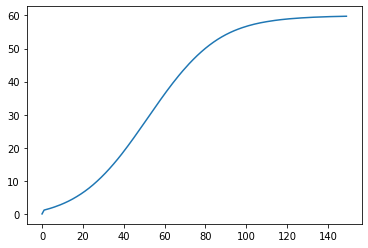

In [171]:
plt.figure()
plt.plot(curva_promedio_1)
plt.plot(curva_promedio_2)
plt.plot(curva_promedio_3)
plt.plot(curva_promedio_4)
plt.plot(curva_promedio_5)
plt.plot(curva_promedio_6)
plt.plot(curva_promedio_7)

In [141]:
np.nanmean(simulaciones[6][0][:,5,1])

2.29845